In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import awkward
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

import tempfile
import atexit
import os
import pickle
import imp

from tqdm import tqdm_notebook as tqdm

In [2]:
from DeepJetCore.DataCollection import DataCollection
from DeepJetCore.compiled.c_trainDataGenerator import trainDataGenerator
from DeepJetCore.customObjects import get_custom_objects
# from DeepJetCore.training.gpuTools import DJCSetGPUs

from keras.models import load_model
from keras import backend as K

## Plotting and Visualization Tools

In [3]:
def plotHist(axes, data, xlabel, ylabel, title, Nbins = 100, range=None, xlog=False, ylog=False):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    if xlog:
        axes.set_xscale('log')
        Nbins = np.logspace(np.log10(data.min()),np.log10(data.max()),Nbins)
    return axes.hist(data, bins=Nbins, range=range, histtype='step', log=ylog); 
    
def plotHist_absxlog(axes, data, xlabel, ylabel, title, Nbins = 100, ylog=False):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.set_xscale('log')
    Nbins = np.logspace(np.log10(np.abs(data).min()),np.log10(np.abs(data).max()),Nbins)
    axes.hist(data, bins=Nbins, histtype='step', log=ylog); 
    
def plotHist_layers(data, ylabel, title, xlabel="Layer", log=True):
    fig,axes = plt.subplots(figsize=(10, 7));
    axes.set_xlabel(xlabel)
    axes.set_xticks(np.arange(53)+0.5, minor=True)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.hist(data, range=(0,60), bins=np.arange(62)-0.5, log=log, histtype='step', linewidth = '1.5');
    plt.grid(True, which='minor', axis='x', linewidth='0.5')
    return fig

## Preliminary Data Exploration

In [324]:
inputfile = '../data/train_data/100.djctd'

# define train_data as our data collection, read from djcdc file
train_data = DataCollection("../data/train_data/example_dataCollection.djcdc")

train_data.dataclass()

In [325]:
# define td as the train_data data collection's dataclass (i.e. TrainData_PF_graph)
td = train_data.dataclass()
td.readFromFile(inputfile)

# dataclass contents: features, weights, truth
features = td.transferFeatureListToNumpy()
weights = td.transferWeightListToNumpy()
truth = td.transferTruthListToNumpy()

# actually convert to np array
features_np = np.array(features)
weights_np = np.array(weights)
truth_np = np.array(truth)

# print("FEATURES: ")
# print(features_np)
# print("WEIGHTS: ")
# print(weights_np)
# print("TRUTH: ")
# print(truth_np)

print("features shape: ")
print(features_np.shape)
print("weights shape: ")
print(weights_np.shape)
print("truth shape: ")
print(truth_np.shape)

features shape: 
(1, 2249, 200, 6)
weights shape: 
(0,)
truth shape: 
(1, 2249, 200, 11)


### Description
Each cell/tracker sensor is assigned to exactly one truth particle, or labelled as noise. The sensor is assigned to the truth particle that leaves the largest energy deposit in that sensor; if this is less than 5% of the total truth particle energy, the sensor hit is labelled as noise. 

The 200 highest-energy hits are vertices in a graph. We use a GNN to predict the momentum and position of each particle alongside object condensation parameters. 

The inputs are energy an position information of each vertex. After one batch normalization layer on theinputs, the NN architecture consists of 6 subsequent blocks. In each block, the mean of all features is concatenated to the block input, followed by two dense layers, one batch normalization layer, and another dense layer. Dense layers have 64 nodes each and use elu activation functions. The output of the dense layers is fed through one GravNet layer. This layer is configured to project the input features to 4 latent spae dimensions and 64 features to be propagated from 10 neighbor vertices in the latent space. After aggregation, 128 output filters are applied. This output is then passed on to the next block and simultaneously compressed by one dense layer with 32 nodes and elu activation before it is added to a list of all block outputs. After 6 blocks, this final list, now with 192 features per vertex, is processed by one dense layer with 64 nodes and elu activation before the final NN outputs are predicted.

Training dataset contains 1-9 particles per event, out of which 50% are electrons and 50% are photons. In total, 1.5 million events are used for training and 250,000 for validation. The model is trained with tensorflow, keras, and the DeepJetCore framework for 20 epochs with a learning rate of $3 \cdot 10^{-4}$ and for 90 epochs with a learning rate of $3 \cdot 10^{-5}$ using the Adam optimiser. The performance is evaluated on statistically independent test samples... condensation threshold: $t_{\beta} = 0.1$ and $t_{d} = 0.8$

## Mapping

Particle Loss Dictionary
https://github.com/jkiesele/SOR/blob/317984a246d98e7d68d9b598745d0c9a3cedc596/modules/inference.py

input features as
B x V x F  already reshaped in network
with F = colours
and B = max number of samples in batch (not batch size!)
(???) V = number of vertices?

truth as 
B x P x T
with T = [mask, true_posx, true_posy, ID_0, ID_1, ID_2, true_width, true_height, n_objects]
(???) P = number of true partifles?

all outputs in B x V x 1/F form except
n_active: B x 1

truth (???):

outdict['t_mask'] =  truth[:,:,0:1]
outdict['t_E']    =  truth[:,:,1:2]
outdict['t_pos']  =  truth[:,:,2:4]
outdict['t_ID']   =  truth[:,:,4:6]
outdict['t_objidx']= truth[:,:,6:7]

outdict['t_rhpos']= truth[:,:,7:10]
outdict['t_rhid']= truth[:,:,10:11]

isElectron,
isGamma,
isPositron,
true_energy,
true_x,
true_y,
etc (???)

aka...

t_mask
t_energy
t_x
t_y
t_iselectron
t_isgamma
t_idx
i_rhx
i_rhy
i_rhz
i_rhid

features (???):

rechit_energy,
rechit_x,
rechit_y,
rechit_z,
rechit_layer,
rechit_detid,


p_beta    = Dense(1,activation='sigmoid')(x)
p_tpos    = ScalarMultiply(10.)(Dense(2)(x))
p_ID      = Dense(2,activation='softmax')(x)
p_E       = ScalarMultiply(10.)(Dense(1)(x))
p_ccoords = ScalarMultiply(10.)(Dense(2)(x))

predictions=Concatenate()([p_beta , # 0 
                           p_E    ,  # 1
                           p_tpos   , #2,3
                           p_ID     , # 4,5
                           p_ccoords, # 6,7
                           ids,         #8 
                           energy_raw]) # 9, 10(posx), 11(posy)

In [326]:
def create_particle_dictionary(feat, truth, pred):
    '''
    input features as
    B x V x F  already reshaped in network
    with F = colours
    and B = number of samples in batch (diff from batch size)
    (???) V = number of vertices?

    truth as 
    B x P x T
    with T = [mask, true_posx, true_posy, ID_0, ID_1, ID_2, true_width, true_height, n_objects]
    (???) P = number of true partifles?

    all outputs in B x V x 1/F form except
    n_active: B x 1
    '''
    outdict = {}

    if truth is not None:
        outdict['t_mask'] =  truth[:,:,0:1]
        outdict['t_E']    =  truth[:,:,1:2]
        outdict['t_pos']  =  truth[:,:,2:4]
        outdict['t_ID']   =  truth[:,:,4:6]
        outdict['t_objidx']= truth[:,:,6:7]

        outdict['t_rhpos']= truth[:,:,7:10]
        outdict['t_rhid']= truth[:,:,10:11]
    #n_objects = truth[:,0,0,8]

    if pred is not None:
        outdict['p_beta']      =  pred[:,:,0:1]
        outdict['p_E_corr']    =  pred[:,:,1:2]
        outdict['p_pos_offs']  =  pred[:,:,2:4]
        outdict['p_ID']        =  pred[:,:,4:6]

        outdict['p_ccoords'] = pred[:,:,6:8]

    if feat is not None:
        outdict['f_E'] = feat[:,:,0:1]
        outdict['f_pos'] = feat[:,:,1:3]
        
        # unsure but maybe include rechit_layer, rechit_detid ??... may be switched
        outdict['f_ID'] = feat[:,:,3:5]
        outdict['f_l'] = feat[:,:,5:6]
        
    return outdict

In [327]:
particle_dict = create_particle_dictionary(features_np[0], truth_np[0], None)
print(particle_dict.keys())

# truth dimensions
for key, value in particle_dict.items():
    print("{} dimensions: {}".format(key, value.shape))

# # print a view
# print(particle_dict['t_E'][0][0:5])

dict_keys(['t_mask', 't_E', 't_pos', 't_ID', 't_objidx', 't_rhpos', 't_rhid', 'f_E', 'f_pos', 'f_ID', 'f_l'])
t_mask dimensions: (2249, 200, 1)
t_E dimensions: (2249, 200, 1)
t_pos dimensions: (2249, 200, 2)
t_ID dimensions: (2249, 200, 2)
t_objidx dimensions: (2249, 200, 1)
t_rhpos dimensions: (2249, 200, 3)
t_rhid dimensions: (2249, 200, 1)
f_E dimensions: (2249, 200, 1)
f_pos dimensions: (2249, 200, 2)
f_ID dimensions: (2249, 200, 2)
f_l dimensions: (2249, 200, 1)


[2.1058379e+02 1.6901669e+02 1.3303032e+02 ... 1.2264234e-02 1.1864383e-02
 1.1542415e-02]


(array([4.11764e+05, 1.09000e+04, 4.41100e+03, 2.57800e+03, 1.77300e+03,
        1.31100e+03, 1.08100e+03, 8.29000e+02, 7.89000e+02, 6.36000e+02,
        6.13000e+02, 5.28000e+02, 4.86000e+02, 4.52000e+02, 3.99000e+02,
        3.98000e+02, 3.82000e+02, 3.61000e+02, 3.62000e+02, 3.20000e+02,
        3.63000e+02, 3.28000e+02, 3.45000e+02, 3.00000e+02, 2.85000e+02,
        2.98000e+02, 3.35000e+02, 3.03000e+02, 2.72000e+02, 2.97000e+02,
        2.93000e+02, 2.85000e+02, 2.75000e+02, 2.54000e+02, 2.78000e+02,
        2.40000e+02, 2.39000e+02, 2.55000e+02, 2.58000e+02, 2.45000e+02,
        2.40000e+02, 2.05000e+02, 2.21000e+02, 2.00000e+02, 2.21000e+02,
        2.19000e+02, 1.83000e+02, 1.57000e+02, 1.77000e+02, 1.63000e+02,
        1.62000e+02, 1.32000e+02, 1.14000e+02, 9.20000e+01, 1.05000e+02,
        8.20000e+01, 7.40000e+01, 6.70000e+01, 6.60000e+01, 6.40000e+01,
        6.40000e+01, 6.30000e+01, 4.90000e+01, 4.90000e+01, 4.40000e+01,
        4.70000e+01, 5.60000e+01, 3.80000e+01, 3.10

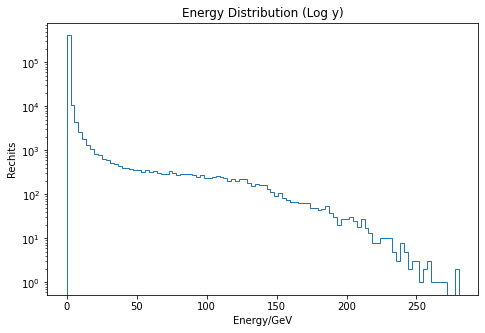

In [343]:
# figs = []

# def plotRechitEnergy(rechit_energy, title_target):
#     title = "Energy Distribution"
#     fig = plt.figure(figsize=(17,5))
#     ax1 = fig.add_subplot(121)
#     plotHist(ax1, rechit_energy, 'Energy/GeV', 'Rechits', title, Nbins = 100, ylog=True)
#     ax2 = fig.add_subplot(122)
#     plotHist(ax2, rechit_energy, 'Energy/GeV', 'Rechits', title, Nbins = 100, xlog=True, ylog=True)
#     return fig

#figs.append(plotRechitEnergy(e, "Rechit"))

rechit_energy = np.reshape(particle_dict['f_E'], [-1])

print(rechit_energy)

fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(121)
plotHist(ax1, rechit_energy, 'Energy/GeV', 'Rechits', 'Energy Distribution (Log y)', Nbins = 100, ylog=True)
# ax2 = fig.add_subplot(122)
# plotHist(ax2, rechit_energy, 'Energy/GeV', 'Rechits', 'Energy Distribution (Log x)', Nbins = 100, xlog=True, ylog=True)

# Object Condensation

## Object Condensation Training Pipeline: Tensorflow Implementation

In [9]:
# clear td variable (so we don't interfere with later declarations in this notebook)
td.clear()

In [10]:
# import DeepJetCore
# from DeepJetCore.training.training_base import training_base
# from DeepJetCore.DataCollection import DataCollection
# import keras
# from keras.models import Model
# from keras.layers import  Reshape, Dense,Conv1D, Conv2D, BatchNormalization, Multiply, Concatenate, Dropout,MaxPooling2D, $
# from Layers import Conv2DGlobalExchange, PadTracker, CropTracker, TileCalo, GaussActivation, Tile2D, TileTrackerFeatures
# from DeepJetCore.DJCLayers import ScalarMultiply, Clip, SelectFeatures, Print

# from tools import plot_pred_during_training, plot_truth_pred_plus_coords_during_training, plot_particle_resolution_during_$
# import tensorflow as tf
# import os

# from Layers import GravNet_simple, GlobalExchange
# from Losses import particle_condensation_loss,dummy


# # set training parameters
# nbatch=550 #120 #1*7

# plots_after_n_batch=1 #1000
# use_event=0
# learningrate=3e-4 #-4

# momentum=0.6

# # define output predictions format
# def output_block(x,ids,energy_raw):
#     p_beta    = Dense(1,activation='sigmoid')(x)
#     p_tpos    = ScalarMultiply(10.)(Dense(2)(x))
#     p_ID      = Dense(2,activation='softmax')(x)

#     p_E       = (Dense(1)(x))
#     p_ccoords = ScalarMultiply(10.)(Dense(2)(x))

#     predictions=Concatenate()([p_beta ,
#                                p_E    ,
#                                p_tpos   ,
#                                p_ID     ,
#                                p_ccoords,
#                                ids,
#                                energy_raw])

#     print('predictions',predictions.shape)
#     return predictions

# # get ids from features list ??
# def checkids(Inputs):
#     return SelectFeatures(5,6)(Inputs[0])

# # define the model for training
# def minimodel(Inputs,feature_dropout=-1.):
#     x = Inputs[0] #this is the self.x list from the TrainData data structure
#     energy_raw = SelectFeatures(0,3)(x)

#     x = BatchNormalization(momentum=0.6)(x)
#     feat=[x]

#     for i in range(6):
#         #add global exchange and another dense here
#         x = GlobalExchange()(x)
#         x = Dense(64, activation='elu')(x)
#         x = Dense(64, activation='elu')(x)
#         x = BatchNormalization(momentum=0.6)(x)
#         x = Dense(64, activation='elu')(x)
#         x = GravNet_simple(n_neighbours=10, 
#                  n_dimensions=4, 
#                  n_filters=128, 
#                  n_propagate=64)(x)
#         x = BatchNormalization(momentum=0.6)(x)
#         feat.append(Dense(32, activation='elu')(x))

#     x = Concatenate()(feat)
#     x = Dense(64, activation='elu')(x)

#     return Model(inputs=Inputs, outputs=output_block(x,checkids(Inputs),energy_raw))

# # initialize instance of training_base class
# train=training_base(testrun=False,resumeSilently=True,renewtokens=False)

# import os
# os.system('cp /storage/user/abao/abao/SOR/modules/betaLosses.py '+train.outputDir+'/')

# from tools import plot_pixel_3D_clustering_flat_during_training_graph

# #samplepath = "/data/hgcal-0/store/jkiesele/SOR/Dataset/test_wiggle/100.djctd"
# #samplepath = train.val_data.getSamplePath(train.val_data.samples[0])
# samplepath = "/storage/user/abao/abao/SOR/data/test_data/9.djctd"

# # weight decay function
# def decay_function(ncalls):
#     #print('call decay')
#     #return 500
#     if ncalls > 1000:
#         return 500
#     if ncalls > 200:
#         return 50
#     if ncalls > 100:
#         return 20
#     return 10

# # resolution (??) weight  decay function
# def reso_decay_function(ncalls):
#     #print('call decay')
#     #return 500
#     if ncalls > 1000:
#         return 3000
#     if ncalls > 200:
#         return 1000
#     if ncalls > 100:
#         return 50
#     return 30

# #only plots calo but fine
# ppdts= [plot_pixel_3D_clustering_flat_during_training_graph(
#                samplefile=samplepath,
#                output_file=train.outputDir+'/train_progress'+str(i),
#                use_event=use_event+i,
#                afternbatches=plots_after_n_batch,
#                on_epoch_end=False,
#                mask=False,
#                ccorrdsx_idx=6,
#                ccorrdsy_idx=7,
#                #cut_truth=16*16,
#                assoindex=6,
#                feat_x=1,
#                feat_y=3,
#                feat_z=2,
#                decay_function=decay_function
#                ) for i in range(5) ]

# resoplot = plot_particle_resolution_during_training(
#     outfilename=train.outputDir+'/resolution',
#     samplefile=samplepath,
#     after_n_batches=1,
#     decay_function=reso_decay_function,
#     use_event=-1
#     )

# # continue training from previous snapshot
# if not train.modelSet(): # allows to resume a stopped/killed training. Only sets the model if it cannot be loaded from pre$

#     #for regression use the regression model
#     train.setModel(minimodel)#model)

#     #read weights where possible from pretrained model
#     #import os
#     #from DeepJetCore.modeltools import load_model, apply_weights_where_possible
#     #m_weights =load_model(os.environ['DEEPJETCORE_SUBPACKAGE'] + '/pretrained/gravnet_1.h5')
#     #train.keras_model = apply_weights_where_possible(train.keras_model, m_weights)

#     #for regression use a different loss, e.g. mean_squared_error

# # compile model
# train.compileModel(learningrate=learningrate,
#                    #loss=dummy,
#                    loss=particle_condensation_loss,
#                    #clipnorm=1
#                    )#metrics=[pixel_over_threshold_accuracy]) 

# # print model summary
# print(train.keras_model.summary())
# #exit()

# # handle callbacks
# print(len(ppdts))
# ppdts_callbacks=[ppdts[i].callback for i in range(len(ppdts))]
# ppdts_callbacks.append(resoplot)

# verbosity=2

# #train.change_learning_rate(learningrate/10.)
# model,history = train.trainModel(nepochs=20, 
#                                  batchsize=int(nbatch),
#                                  checkperiod=10, # saves a checkpoint model every N epochs
#                                  verbose=verbosity,
#                                  additional_callbacks=ppdts_callbacks)
# print('reducing learning rate')
# train.change_learning_rate(learningrate/10.)

# model,history = train.trainModel(nepochs=100+20, 
#                                  batchsize=nbatch,
#                                  checkperiod=10, # saves a checkpoint model every N epochs
#                                  verbose=verbosity,
#                                  additional_callbacks=ppdts_callbacks)

# print('reducing learning rate')
# train.change_learning_rate(learningrate/10.)

# model,history = train.trainModel(nepochs=200, 
#                                  batchsize=nbatch,
#                                  checkperiod=10, # saves a checkpoint model every N epochs
#                                  verbose=verbosity,
#                                  additional_callbacks=ppdts_callbacks)


In [11]:
# import subprocess

# os.getcwd()
# # SOR_dir = "/storage/user/abao/abao/SOR"
# train_bashCommand = "python3 ../Train/train.py ../data/train_data/dataCollection.djcdc ../results_1"
# process = subprocess.Popen(train_bashCommand.split(), stdout=subprocess.PIPE)
# output, error = process.communicate()
# print(output)

## Object Condensation Prediction Pipeline

In [12]:
# clear td variable (so we don't interfere with later declarations in this notebook)
td.clear()

In [13]:
### see https://github.com/DL4Jets/DeepJetCore/blob/master/bin/predict.py

# prediction outputs
outputs = []

# get batchsize from train_data data collection
batchsize = -1

# DJCSetGPUs(args.gpu)

# use as input model a previously (partially) trained model with same train_data data collection
inputModel = "../results_partial/KERAS_check_best_model.h5"
custom_objs = get_custom_objects()
model = load_model(inputModel, custom_objects=custom_objs)

# File Paths
# file that we are generating predictions for
inputfile = '../data/train_data/1.djctd'
# same directory as input file
outputDir = os.path.dirname(inputfile) + "/predictions"
outputfilename = "pred_"+os.path.basename(inputfile)
outputfile = outputDir + "/" + outputfilename
print(inputfile)
print(outputfile)

# define td as the train_data data collection's dataclass (i.e. TrainData_PF_graph)
td = train_data.dataclass()
td.readFromFile(inputfile)

# define training data generator class instance gen and set its variables
print('predicting ',inputfile)
gen = trainDataGenerator()
if batchsize < 1:
    batchsize = train_data.getBatchSize()
print('batch size', batchsize)
gen.setBatchSize(batchsize)
gen.setSquaredElementsLimit(train_data.batch_uses_sum_of_squares)
gen.setSkipTooLargeBatches(False)
gen.setBuffer(td)

# data generator function
def genfunc():
    while(not gen.isEmpty()):
        d = gen.getBatch()
        yield d.transferFeatureListToNumpy() , d.transferTruthListToNumpy()

# predictions
predicted = model.predict_generator(genfunc(),
                                    steps=gen.getNBatches(),
                                    max_queue_size=1,
                                    use_multiprocessing=False,verbose=1)

# dataclass contents: features, weights, truth
# note: must convert these to numpy at the end of we mess things up
features = td.transferFeatureListToNumpy()
weights = td.transferWeightListToNumpy()
truth = td.transferTruthListToNumpy()

# actually convert to np array
features_np = np.array(features)
weights_np = np.array(weights)
truth_np = np.array(truth)

# clear variables
td.clear()
gen.clear()

if not type(predicted) == list: #circumvent that keras return only an array if there is just one list item
    predicted = [predicted]   

pred (None, 200, 12)
Mki (None, 200, None)
kalpha (None, None)
x_kalpha <unknown>
Mki (None, 200, None)
kalpha (None, None)
x_kalpha <unknown>
Mki (None, 200, None)
kalpha (None, None)
x_kalpha <unknown>
Mki (None, 200, None)
kalpha (None, None)
x_kalpha <unknown>
Mki (None, 200, None)
kalpha (None, None)
x_kalpha <unknown>
Mki (None, 200, None)
kalpha (None, None)
x_kalpha <unknown>
Mki (None, 200, None)
kalpha (None, None)
x_kalpha <unknown>
Mki (None, 200, None)
kalpha (None, None)
x_kalpha <unknown>
Mki (None, 200, None)
kalpha (None, None)
x_kalpha <unknown>
Nobj (None,)
Nobj (None,)
../data/train_data/1.djctd
../data/train_data/predictions/pred_1.djctd
predicting  ../data/train_data/1.djctd
batch size 1
Instructions for updating:
Please use Model.predict, which supports generators.
2249/2249 [==============================] - 24s 11ms/step


In [14]:
# predictions=Concatenate()([p_beta , # 0 
#                            p_E    ,  # 1
#                            p_tpos   , #2,3
#                            p_ID     , # 4,5
#                            p_ccoords, # 6,7
#                            ids,         #8 
#                            energy_raw]) # 9, 10(posx), 11(posy)

In [15]:
print("PREDICTIONS: ")
# print(predicted)

predicted_np = np.array(predicted)

td.writeOutPrediction(predicted, features, truth, weights, outputfile, inputfile)
        
outputs.append(outputfilename)

print("sample view of predicted: ")
print(predicted_np[0][0][0])
print("sample view of truth: ")
print(truth_np[0][0][0])

with open(outputDir + "/outfiles.txt","w") as f:
    for l in outputs:
        f.write(l+'\n')

PREDICTIONS: 
writeout
predicted (2249, 200, 12)
features (2249, 200, 6)
truth (2249, 200, 11)
sample view of predicted: 
[ 9.9358219e-01  8.9633167e-01 -1.4621300e-01 -3.9307162e-01
  8.0293244e-01  1.9706748e-01 -1.8932699e+00 -4.7628803e+00
  2.0260000e+03  2.0539420e+02 -2.4750000e+01  5.7750000e+01]
sample view of truth: 
[ 1.0000000e+00  1.9737604e+02 -2.3920635e+01  5.5204815e+01
  1.0000000e+00  0.0000000e+00  2.0000000e+00 -2.4750000e+01
  5.7750000e+01 -4.9700001e+01  2.0260000e+03]


In [16]:
particle_dict = create_particle_dictionary(features_np[0], truth_np[0], predicted_np[0])
print(particle_dict.keys())

# truth dimensions
for key, value in particle_dict.items():
    print("{} dimensions: {}".format(key, value.shape))

# # print a view
# print(particle_dict['p_beta'])

dict_keys(['t_mask', 't_E', 't_pos', 't_ID', 't_objidx', 't_rhpos', 't_rhid', 'p_beta', 'p_E_corr', 'p_pos_offs', 'p_ID', 'p_ccoords', 'f_E', 'f_pos', 'f_ID', 'f_l'])
t_mask dimensions: (2249, 200, 1)
t_E dimensions: (2249, 200, 1)
t_pos dimensions: (2249, 200, 2)
t_ID dimensions: (2249, 200, 2)
t_objidx dimensions: (2249, 200, 1)
t_rhpos dimensions: (2249, 200, 3)
t_rhid dimensions: (2249, 200, 1)
p_beta dimensions: (2249, 200, 1)
p_E_corr dimensions: (2249, 200, 1)
p_pos_offs dimensions: (2249, 200, 2)
p_ID dimensions: (2249, 200, 2)
p_ccoords dimensions: (2249, 200, 2)
f_E dimensions: (2249, 200, 1)
f_pos dimensions: (2249, 200, 2)
f_ID dimensions: (2249, 200, 2)
f_l dimensions: (2249, 200, 1)


In [17]:
print("sample predicted energy correction (p_E_corr) from predicted: ")
print(particle_dict['p_E_corr'][0][0:5])
print("sample truth energy (t_E) from truth: ")
print(particle_dict['t_E'][0][0:5])

sample predicted energy correction (p_E_corr) from predicted: 
[[0.89633167]
 [1.2975289 ]
 [1.3342274 ]
 [0.98950076]
 [1.833063  ]]
sample truth energy (t_E) from truth: 
[[197.37604 ]
 [197.37604 ]
 [171.38068 ]
 [ 84.529854]
 [ 84.529854]]


(array([2.0000e+00, 0.0000e+00, 5.0000e+00, 1.2000e+01, 1.8000e+01,
        4.0000e+01, 5.5000e+01, 1.0300e+02, 1.5500e+02, 1.9000e+02,
        2.9600e+02, 3.9500e+02, 5.7100e+02, 6.1300e+02, 8.5700e+02,
        1.0410e+03, 1.2040e+03, 1.4320e+03, 1.6440e+03, 1.9330e+03,
        2.1600e+03, 2.4860e+03, 2.9680e+03, 3.4340e+03, 3.9310e+03,
        4.7060e+03, 5.4590e+03, 6.3340e+03, 7.2810e+03, 8.0330e+03,
        8.7390e+03, 9.4140e+03, 1.0058e+04, 1.0336e+04, 1.0855e+04,
        1.1241e+04, 1.1232e+04, 1.1203e+04, 1.1124e+04, 1.1131e+04,
        1.0728e+04, 1.0282e+04, 1.0494e+04, 1.0411e+04, 1.0408e+04,
        1.0291e+04, 1.0227e+04, 1.0351e+04, 1.0520e+04, 1.0288e+04,
        1.0332e+04, 1.0770e+04, 1.3406e+04, 1.0183e+04, 9.2110e+03,
        8.9190e+03, 8.6450e+03, 8.0350e+03, 7.7510e+03, 7.3870e+03,
        6.4980e+03, 6.2680e+03, 6.0270e+03, 5.5760e+03, 5.3250e+03,
        4.9920e+03, 4.7210e+03, 4.5160e+03, 4.3720e+03, 4.1640e+03,
        3.9640e+03, 3.7900e+03, 3.5470e+03, 3.37

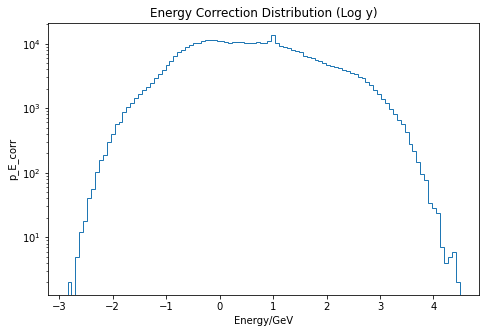

In [18]:
p_E_corr = np.reshape(particle_dict['p_E_corr'],[-1])
    
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(121)
plotHist(ax1, p_E_corr, 'Energy/GeV', 'p_E_corr', 'Energy Correction Distribution (Log y)', Nbins = 100, ylog=True)
# ax2 = fig.add_subplot(122)
# plotHist(ax2, p_E_corr, 'Energy/GeV', 'Rechits', 'Energy Distribution (Log x)', Nbins = 100, xlog=True, ylog=True)

## Condensate Particles

In [19]:
# # collect_condensates as defined in inference
# def collect_condensates(data, 
#                           beta_threshold, distance_threshold):
    
#     betas   = np.reshape(data['p_beta'], [data['p_beta'].shape[0], -1])
#     ccoords = np.reshape(data['p_ccoords'], [data['p_ccoords'].shape[0], -1, data['p_ccoords'].shape[-1]])
    
#     sorting = np.argsort(-betas, axis=1)
    
#     betasel = betas > beta_threshold
    
#     bsel =  c_collectoverthresholds(betas, 
#                             ccoords, 
#                             sorting,
#                             betasel,
#                           beta_threshold, distance_threshold)
    
    
# return np.reshape(bsel , data['p_beta'].shape)

In [431]:
from __future__ import print_function
from DeepJetCore.TrainData import TrainData

from evaluation_tools import find_best_matching_truth_and_format, write_output_tree, determine_event_properties, write_event_output_tree
from inference import make_particle_inference_dict,  collect_condensates


allparticles=[]
all_ev_prop=[]
names=""

inputFileDir = "../data/train_data/predictions"
inputFile = "../data/train_data/predictions/outfiles.txt"
outputFile = "../data/train_data/predictions/condensates_1"

with open(inputFile) as file:
    for inputfile in file:
        inputfile = inputfile.replace('\n', '')
        inputfile = inputFileDir + '/' + inputfile
        if len(inputfile)<1: continue

        print('inputfile', inputfile)

        td = TrainData()
        td.readFromFile(inputfile)
        indata = td.transferFeatureListToNumpy()
        pred, feat, truth = indata[0],indata[1],indata[2]
        del td

        d = make_particle_inference_dict(pred, feat, truth)
        condensate_mask = np.squeeze(collect_condensates(d, 0.1, 0.8),axis=2) #B x V x 1
        
        print(condensate_mask.shape)
        
        pred_E   = d['f_E']* d['p_E_corr']
        pred_pos = d['f_pos'] + d['p_pos_offs']
        calo_energy = None #not supported by data format..
        #np.sum(d['f_E'][:,0:16*16,0],axis=-1)#calo energy
        #loop over events here.. easier
        
        print("predictions shape: ", pred.shape)
        nevents = pred.shape[0]
        all_idxs = np.array([i for i in range(pred.shape[1])])

        #print('pred_pos',pred_pos.shape)
        #print('all_idxs',all_idxs.shape)
        
        # read more at: https://github.com/jkiesele/SOR/blob/master/modules/evaluation_tools.py
        for event in range(nevents):
            ev_pred_E    = pred_E[event][condensate_mask[event]>0][:,0]
#             print(ev_pred_E)
            ev_pred_pos  = pred_pos[event][condensate_mask[event]>0]
            ev_truth = truth[event]
#             print(ev_truth)
            ob_idx = all_idxs[condensate_mask[event]>0]
            
            # matched_posx, matched_posy, matched_e, matched_id, not_recoed_pos, not_recoed_e, not_recoed_id
            eventparticles = find_best_matching_truth_and_format(ev_pred_pos, ev_pred_E, ob_idx, ev_truth)
#             print(eventparticles)
            allparticles.append(eventparticles)

            ev_pro, names = determine_event_properties(eventparticles, None)
            all_ev_prop.append(ev_pro)
print("number of events: ", nevents)
print("event property names: ", names)
allparticles = np.concatenate(allparticles,axis=0)
all_ev_prop = np.concatenate(all_ev_prop,axis=0)
print("all particles shape: ", allparticles.shape)
print("all events shape: ", all_ev_prop.shape)

#is_reco, reco_posx, reco_posy, reco_e, is_true, true_posx, true_posy, true_e, true_id
print('efficiency: ', float(np.count_nonzero( allparticles[:,0] *  allparticles[:,4]))/float( np.count_nonzero(allparticles[:,4] ) ))
print('fake: ', float(np.count_nonzero( allparticles[:,0] *  (1.-allparticles[:,4])))/float( np.count_nonzero(allparticles[:,0] ) ))

write_output_tree(allparticles, outputFile)
write_event_output_tree(all_ev_prop, names, outputFile)


inputfile ../data/train_data/predictions/pred_1.djctd
(2249, 200)
predictions shape:  (2249, 200, 12)
number of events:  2249
event property names:  jet_mass_r_pu0.0, jet_mass_t_pu0.0, p_imbalance_x_r_pu0.0, p_imbalance_x_t_pu0.0,jet_mass_r_pu0.2, jet_mass_t_pu0.2, p_imbalance_x_r_pu0.2, p_imbalance_x_t_pu0.2,jet_mass_r_pu0.5, jet_mass_t_pu0.5, p_imbalance_x_r_pu0.5, p_imbalance_x_t_pu0.5,jet_mass_r_pu0.8, jet_mass_t_pu0.8, p_imbalance_x_r_pu0.8, p_imbalance_x_t_pu0.8,n_true, e_access_n
all particles shape:  (11412, 10)
all events shape:  (2249, 18)
efficiency:  0.5474012069301148
fake:  0.16829340431824905


## Plot visualizations of condensates 

In [21]:
# same thing as make_particle_resolution_plots in tools.py in modules, but modified to show inline in notebook
def custom_make_particle_resolution_plots(feat,predicted,truth):
    from inference import make_particle_inference_dict, collect_condensates
    d = make_particle_inference_dict(predicted, feat , truth)
    # B x V x F
    pred_E   = d['f_E']* d['p_E_corr']
    pred_pos = d['f_pos'] + d['p_pos_offs']
        
    condensate_mask = collect_condensates(d, 0.1, 0.8) #B x V x 1
    condensate_mask = np.reshape(condensate_mask, [condensate_mask.shape[0],condensate_mask.shape[1]]) #B x V 
    
    print("condensate_mask shape: ", condensate_mask.shape)
    
    n_condensates = np.sum(condensate_mask, axis=-1, keepdims=True) #B x 1
    
    # get number of true particles for each event(?) by taking maximum of true object ids (t_objidx) among V dim
    n_true_particles = np.reshape(np.max(d['t_objidx'],axis=1)+1., [d['t_objidx'].shape[0],1])  #B x 1 x 1
    
    
    print("n_condensates")
    print("n_condensates shape: ", n_condensates.shape)
    print(n_condensates)
    print("n_true_particles")
    print("n_true_particles shape: ", n_true_particles.shape)
    print(n_true_particles)
    
    
    n_total_condensates = np.sum(n_condensates)
    
    print("n_total_condensates")
    print(n_total_condensates)
    
    n_total_true_particles = np.sum(n_true_particles)
    print("n_total_true_particles")
    print(n_total_true_particles)
        
    print('fraction of right number: ',float(np.sum(n_condensates==n_true_particles))/float(n_true_particles.shape[0]))
    
    # flatten to 1-D representation
    flat_cond_mask =  np.reshape(condensate_mask, [-1])
        
    flat_E_true = np.reshape(d['t_E'],[-1])
    flat_E_pred = np.reshape(pred_E,[-1])
        
    E_resolution = flat_E_pred*flat_cond_mask/(flat_E_true+0.0001) # B x V x 1
    #E_variance = 
        
    E_resolution = E_resolution[flat_cond_mask>0]
    sel_E_true = flat_E_true[flat_cond_mask>0]
    
    
    #energy resolution
    fig = plt.figure(figsize=(18, 6))
    axs = [fig.add_subplot(1,2,1),
            fig.add_subplot(1,2,2)]
    
    axs[0].hist(E_resolution,bins=29, range=[0.93,1.07])
    axs[1].hist2d(sel_E_true,E_resolution,bins=21, range=[[0,200],[0.9,1.1]])
    
    axs[0].set_title("Energy Resolution")
    axs[0].set_xlabel("Energy Resolution")
    axs[0].set_ylabel("Count")
    
    axs[1].set_title("Energy Resolution vs. True Energy")
    axs[1].set_xlabel("Energy/GeV")
    axs[1].set_ylabel("Energy Resolution")
    
    plt.show()
    
#     fig.savefig(outfile, dpi=300)
    
#     fig.clear()
#     plt.close(fig)
#     plt.clf()
#     plt.cla()
#     plt.close() 

pred (2249, 200, 12)
feat (2249, 200, 6)
truth (2249, 200, 11)
condensate_mask shape:  (2249, 200)
n_condensates
n_condensates shape:  (2249, 1)
[[5]
 [3]
 [3]
 ...
 [2]
 [3]
 [4]]
n_true_particles
n_true_particles shape:  (2249, 1)
[[7.]
 [4.]
 [7.]
 ...
 [3.]
 [4.]
 [6.]]
n_total_condensates
6762
n_total_true_particles
10000.0
fraction of right number:  0.09337483325922633


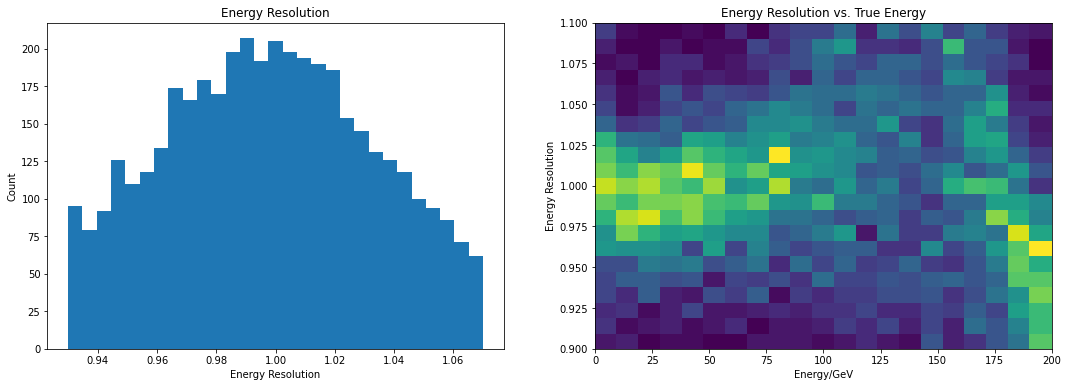

In [22]:
# matplotlib as mpl imported earlier
mpl.use('Agg') 
# from tools import make_particle_resolution_plots

inputFile = "../data/train_data/predictions/pred_1.djctd"

#just read the stored data
td = TrainData()
td.readFromFile(inputFile)
indata = td.transferFeatureListToNumpy()
pred, feat, truth = indata[0],indata[1],indata[2]
del td

print('pred',pred.shape)
print('feat',feat.shape)
print('truth',truth.shape)

# make_particle_resolution_plots(feat, pred, truth, outfile="reso.pdf")
custom_make_particle_resolution_plots(feat, pred, truth)


In [23]:
# from wand.image import Image as WImage
# img = WImage(filename='reso.pdf')
# img

## Explore Condensate Output Files

# Dynamic Reduction Network with Object Condensation

In [24]:
# # data structure class for training... mimics C-like struct
# class DRN_TrainData_PF():
#     def __init__(self, x=None, batch=None):
#         # features
#         self.x = x
# #         # targets
# #         self.y = y
#         # tensor assigning batches to nodes
#         self.batch = batch

In [300]:
# all events from object condensation
all_ev_prop_tensor = torch.from_numpy(all_ev_prop)
all_ev_prop_tensor

tensor([[ 5.0018e+02,  6.0139e+02, -2.6360e+04,  ..., -2.0235e+04,
          7.0000e+00,  0.0000e+00],
        [ 2.8792e+02,  3.4471e+02,  1.5791e+04,  ...,  3.7511e+03,
          4.0000e+00,  0.0000e+00],
        [ 1.2328e+02,  5.7804e+02,  9.9223e+03,  ..., -6.5212e+03,
          7.0000e+00,  0.0000e+00],
        ...,
        [ 2.6284e+02,  3.3529e+02,  6.4947e+03,  ...,  2.6220e+03,
          3.0000e+00,  0.0000e+00],
        [ 3.3423e+02,  4.1547e+02, -3.4433e+04,  ..., -1.9189e+04,
          4.0000e+00,  0.0000e+00],
        [ 6.0678e+02,  7.1857e+02, -4.6898e+03,  ..., -7.7536e+03,
          6.0000e+00,  0.0000e+00]])

## Estimator for Pytorch Training

In [350]:
"""
This module contains the Estimator class implementation which provides
code for doing the training of a PyTorch model.
"""

from __future__ import print_function

from datetime import datetime
from timeit import default_timer as timer

import numpy as np

import shutil 
import os
import copy 

import torch

from torch_geometric.data import Batch      

from Losses import particle_condensation_loss

def logger(s):
    """Simple logger function which prints date/time"""
    print(datetime.now(), s)

class Estimator():
    """Estimator class"""

    def __init__(self, model, loss_func, opt='Adam',
                 train_losses=None, valid_losses=None,
                 cuda=False, l1=0.):

        self.model = model
        if cuda:
            self.model.cuda()
        self.loss_func = loss_func
        if opt == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters())
        elif opt == 'SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters())

        self.train_losses = train_losses if train_losses is not None else []
        self.valid_losses = valid_losses if valid_losses is not None else []
        self.l1 = l1

        logger('Model: \n%s' % model)
        logger('Parameters: %i' %
               sum(param.numel() for param in model.parameters()))

    def l1_penalty(self, arr):
        return torch.abs(arr).sum()
        
    def training_step(self, inputs, targets):
        '''
        Applies single optimization step on batch
        '''
        
        # define data attribiutes
        batch_input_np = np.array(inputs[0])
        batch_target_np = np.array(targets[0])
        print("target shape: ")
        print(batch_target_np.shape)
        batch_input_tensor = torch.from_numpy(batch_input_np)
        batch_target_tensor = torch.from_numpy(batch_target_np)
        
        # kinda jank
        batch_size = len(inputs[0])
        num_nodes = len(inputs[0][0]) # should be 200?
        num_features = len(inputs[0][0][0]) # should be 6
        
        # flatten from 3D to 2D by combining B and V dimmensions
        x_tensor = batch_input_tensor.view(-1, num_features)
        
        # tensor keeping track of which batch each entry is from, after flattening
        batch_list = [i for i in range(batch_size) for j in range(num_nodes)]
#         batch_list = [i for i in range(num_nodes) for j in range(batch_size)]
        batch_np = np.array(batch_list)
        batch_tensor = torch.from_numpy(batch_np)
        
        # cartesian coordinate tensor from x_tensor
        pos_tensor = x_tensor.narrow(1,1,3)

        # put data into a batch structure
        data = Batch(batch=batch_tensor, x=x_tensor, edge_index=None, edge_attr=None, pos=pos_tensor)
        
#         # modify data attributes - zero-suppressed
#         # mask based on energy - keep only sensors/cells with nonzero energy hit
#         mask = (data.x[:,0] > 0.).squeeze()
# #         data.x = torch.cat([data.x, data.pos], dim=-1)
#         data.x = data.x[mask]
#         data.pos = data.pos[mask,:]
#         data.batch = data.batch[mask.squeeze()]
        
        
        print("Applying single optimization step on batch")
        self.model.zero_grad()
        self.optimizer.zero_grad()
        
        # call the forward step of our model
        outputs = self.model(data)
        
#         outputs_np = np.expand_dims(outputs.detach().numpy(), axis=0)
        outputs_np = outputs.detach().numpy()
        print("outputs: ")
        print(outputs.size())
    
        print("targets: ")
#         print(targets)
        print(batch_target_tensor.size())
        
#         # negative log likelihood loss
#         loss = F.nll_loss(outputs, batch_target_tensor)

#         loss = particle_condensation_loss(batch_target_np, outputs_np)
    
#         print(loss)
        
#         loss.backward()

        #print(torch.unique(torch.argmax(result, dim=-1)))
        #print(torch.unique(data.y))
        self.optimizer.step()

#         scheduler.batch_step()
        
        return loss

    def save_checkpoint(self, state, is_best, filename='checkpoint.pt'):
        directory = os.path.dirname(filename)
        try:
            os.stat(directory)
        except:
            os.mkdir(directory)
        torch.save(state, filename)
        if is_best:
            bestfilename = directory+'/model_best.pt'
            shutil.copyfile(filename, bestfilename)
            
    def load_checkpoint(self, filename='checkpoint.pt'):
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.valid_losses = checkpoint['valid_losses']
        self.train_losses = checkpoint['train_losses']
        
    def load_weights(self, filename='checkpoint.pt'):
        checkpoint = torch.load(filename)
        old_model = copy.deepcopy(self.model)
        old_model.load_state_dict(checkpoint['state_dict'])

        def set_masked_data(new_layer, old_layer):
            if new_layer.mask_flag:
                new_layer.weight.data = old_layer.weight.data * old_layer.mask.data
            else:
                new_layer.weight.data = old_layer.weight.data
              
        set_masked_data(self.model.edge_network.network[0], old_model.edge_network.network[0])
        set_masked_data(self.model.edge_network.network[2], old_model.edge_network.network[2])
        set_masked_data(self.model.node_network.network[0], old_model.node_network.network[0])
        set_masked_data(self.model.node_network.network[2], old_model.node_network.network[2])       
    
    def fit_gen(self, train_generator, n_batches=1, n_epochs=1,
                valid_generator=None, n_valid_batches=1, verbose=0, 
                filename='checkpoint.pt'):
        """Runs batch training for a number of specified epochs."""
        epoch_start = len(self.train_losses)
        epoch_end = epoch_start + n_epochs
        if len(self.valid_losses) > 0:
            best_valid_loss = self.valid_losses[-1]
        else:
            best_valid_loss = 99999999
        for i in range(epoch_start, epoch_end):
            logger('Epoch %i' % i)
            start_time = timer()
            sum_loss = 0

            # Train the model
            print("training model...")
            self.model.train()
            
            print("computing losses for {} batches...".format(n_batches))
            for j in range(n_batches):
                batch_input, batch_target = next(train_generator)
                print("batch loss: ")
                batch_loss = (self.training_step(batch_input, batch_target)
                              .cpu().data.item())
                sum_loss += batch_loss
                if verbose > 0:
                    logger('  Batch %i loss %f' % (j, batch_loss))
            end_time = timer()
            avg_loss = sum_loss / n_batches
            self.train_losses.append(avg_loss)
            logger('  training loss %.3g time %gs' %
                   (avg_loss, (end_time - start_time)))

            # TODO: adapt this to new data scheme
            with torch.no_grad():
                # Evaluate the model on the validation set
                if (valid_generator is not None) and (n_valid_batches > 0):
                    self.model.eval()
                    valid_loss = 0
                    for j in range(n_valid_batches):
                        valid_input, valid_target = next(valid_generator)
                        valid_loss += (self.loss_func(self.model(valid_input), valid_target)
                                       .cpu().data.item())
                    valid_loss = valid_loss / n_valid_batches
                    self.valid_losses.append(valid_loss)
                    logger('  validate loss %.3g' % valid_loss)
                
                    #Save model checkpoint - modified
                    logger(' save checkpoint') 
                    is_best = valid_loss < best_valid_loss
                    best_valid_loss = min(valid_loss, best_valid_loss)
                    self.save_checkpoint({
                        'epoch': i + 1,
                        'state_dict': self.model.state_dict(),
                        'best_valid_loss': best_valid_loss,
                        'valid_losses': self.valid_losses,
                        'train_losses': self.train_losses,
                        'optimizer' : self.optimizer.state_dict(),
                    }, is_best, filename=filename)

    def predict(self, generator, n_batches, concat=True):
        with torch.no_grad():  
            self.model.eval()
            outputs = []
            for j in range(n_batches):
                test_input, test_target = next(generator)
                outputs.append(self.model(test_input))
            if concat:
                outputs = torch.cat(outputs)
            return outputs

## Pytorch Implementation: Dynamic Reduction Network

In [419]:
import os
import os.path as osp
import math

import numpy as np
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv, NNConv
from torch_geometric.nn.pool.edge_pool import EdgePooling

from torch_geometric.utils import normalized_cut
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils.undirected import to_undirected
from torch_geometric.nn import (graclus, max_pool, max_pool_x,
                                global_mean_pool, global_max_pool,
                                global_add_pool)

# # something wrong with the package perhaps
# from torch_geometric.nn import GravNetConv

In [420]:
# DRN with some edits to make it work for object condensation and current dataset

transform = T.Cartesian(cat=False)

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

class DynamicReductionNetwork(nn.Module):
    # This model iteratively contracts nearest neighbour graphs 
    # until there is one output node.
    # The latent space trained to group useful features at each level
    # of aggregration.
    # This allows single quantities to be regressed from complex point counts
    # in a location and orientation invariant way.
    # One encoding layer is used to abstract away the input features.
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add',
                 norm=torch.tensor([1.,1.,1.,1.,1.,1.])):
        super(DynamicReductionNetwork, self).__init__()

        self.datanorm = nn.Parameter(norm)
        
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2

        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim//2),            
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
        )        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )                
        
        # The edge convolutional operator from the “Dynamic Graph CNN for Learning on Point Clouds” paper
        self.edgeconv1 = EdgeConv(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv(nn=convnn2, aggr=aggr)
        
#         self.condensation = nn.Sequential(
#             nn.BatchNorm2d(momentum=0.6)
#             feat=[data.x]

#             for i in range(2): # 6
#                 #add global exchange and another dense here
#                 x = GlobalExchange()(x)
#                 x = Dense(64, activation='elu')(x)
#                 x = Dense(64, activation='elu')(x)
#                 x = BatchNormalization(momentum=0.6)(x)
#                 x = Dense(64, activation='elu')(x)
#                 x = nn.GravNetConv(n_neighbours=10, 
#                          n_dimensions=4, 
#                          n_filters=128, 
#                          n_propagate=64)(x)
#                 x = BatchNormalization(momentum=0.6)(x)
#                 feat.append(Dense(32, activation='elu')(x))

#             x = Concatenate()(feat)
#             x = Dense(64, activation='elu')(x)
#         )
        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.ELU(),
                                    nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.ELU(),                                    
                                    nn.Linear(hidden_dim//2, output_dim))
        
        
    def forward(self, data):
        data.x = self.datanorm * data.x
        data.x = self.inputnet(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv1(data.x, data.edge_index)
        
        print("data x shape: ", data.x.size())
            
        weight = normalized_cut_2d(data.edge_index, data.x)
        
        # replace with condensation-based clustering
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        
        data.edge_attr = None
        data = max_pool(cluster, data)
        
        print("data x shape: ", data.x.size())
        
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv2.flow))
        data.x = self.edgeconv2(data.x, data.edge_index)
        
        print("data x shape: ", data.x.size())
                
        weight = normalized_cut_2d(data.edge_index, data.x)
        
        # replace with condensation-based clustering
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        
        x, batch = max_pool_x(cluster, data.x, data.batch)
        
        print("x shape: ", x.size())

        x = global_max_pool(x, batch)
        
#         upsample = nn.modules.Upsample(scale_factor=2, mode="linear")
#         upsample = nn.ConvTranspose2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
#         upsample(x)
        
        print("x shape: ", x.size())
                
        return self.output(x).squeeze(-1)

## PyTorch Implementation: Dynamic Reduction Network with Object Condensation

In [421]:
# clear td variable (so we don't interfere with later declarations in this notebook)
# td.clear()

train_data = DataCollection("../data/train_data/dataCollection.djcdc")

In [422]:
# from estimator import Estimator

# from DynamicReductionNetwork import *

import sklearn.metrics
from sklearn.model_selection import train_test_split

# device = torch.device("cuda" if cuda else "cpu")

# if cuda:
#     np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False).cuda())
# else:
#     np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False))

# if cuda:
#     torch_to_np = lambda x: x.cpu().numpy()
# else:
#     torch_to_np = lambda x: x.detach().numpy()
    

In [424]:
# train_data = DataCollection("../data/train_data/example_dataCollection.djcdc")

# splits off 10% of the training dataset for validation. Can be used in the same way as train_data
val_data = train_data.split(0.9) 

# Set the batch size. 
# If the data is ragged in dimension 1 (see convert options), 
# then this is the maximum number of elements per batch, which could be distributed differently
# to individual examples. E.g., if the first example has 50 elements, the second 48, and the third 30,
# and the batch size is set to 100, it would return the first two examples (in total 99 elements) in 
# the first batch etc. This is helpful to avoid out-of-memory errors during training

train_data.setBatchSize(100)         
    
# prepare the generator
train_data.invokeGenerator()
        
train_data.generator.shuffleFilelist()
# train_data.generator.prepareNextEpoch()

# this number can differ from epoch to epoch for ragged data!
n_train_batches = train_data.generator.getNBatches()


# Model config
hidden_dim = 20
# n_iters = 4
n_features = 6
n_outputs = 12
# number of nearest neighbors?
k = 10

n_epochs = 10 #100
# valid_frac = 0.1
# test_frac = 0

# def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add',
model = DynamicReductionNetwork(input_dim=n_features, hidden_dim=hidden_dim, output_dim=n_outputs, k=k)
# loss function
loss_func = nn.BCELoss()
# estim = Estimator(model, loss_func=loss_func, cuda=cuda, l1 = 0)
estim = Estimator(model, loss_func=loss_func, cuda=None, l1 = 0)

# training data generator
gen = train_data.generator

def genfunc():
    while(not gen.isEmpty()):
        d = gen.getBatch()
        yield d.transferFeatureListToNumpy() , d.transferTruthListToNumpy()

# # test batch generator output
# batch_input, batch_target = next(genfunc())
# print(batch_input)
# print(batch_target)

# fit estimator with data generator(s)
# note there are more arguments: 
# estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
#               valid_generator=valid_batcher, n_valid_batches=n_valid_batches, 
#               filename='test.pt')

estim.fit_gen(genfunc(), n_batches=n_train_batches, n_epochs=n_epochs, filename='checkpoint.pt')


2020-05-18 18:31:07.122646 Model: 
DynamicReductionNetwork(
  (inputnet): Sequential(
    (0): Linear(in_features=6, out_features=10, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ELU(alpha=1.0)
  )
  (edgeconv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ELU(alpha=1.0)
  ))
  (edgeconv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=40, out_features=30, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ELU(alpha=1.0)
  ))
  (output): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=10, out_feature

NameError: name 'loss' is not defined

In [ ]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim(195,300)
#plt.ylim(.06,.08)
plt.legend(loc=0);